In [17]:
import yaml
from pathlib import Path
import pandas as pd
import numpy as np
from collections import defaultdict
from tqdm import tqdm
import matplotlib.pyplot as plt

class Backup:
    def __init__(self):
        self.data_dict = {}

    def save_with_key(self, data, key, copy=False):
        if key in self.data_dict.keys():
            print(f'Data Key "f{key}" already exists, Skip Saving')
        else:
            self.data_dict[key] = data.copy() if copy else data

    def check_key(self, key):
        return key in self.data_dict.keys()

    def copy_data_with_key(self, key):
        return self.data_dict[key].copy()
    
backup = Backup()

with open('../configs/base.yaml', 'r', encoding='utf-8') as file:
    base_config = yaml.safe_load(file)

data_path = base_config['paths']['data_path']
asset_path = base_config['paths']['asset_path']

In [18]:
reload = False

if not backup.check_key('total_df'):
    meta_df = pd.read_csv(f'/media/user/h/minchan/elec_data/assets/03_train_meta_padding.csv', usecols=['is_dummy', 'num', 'datetime', 'yeartag'])
    elec_df = pd.read_csv(f'/media/user/h/minchan/elec_data/assets/03_train_elec_padding.csv', usecols=['elec'])
    total_df = pd.concat([meta_df, elec_df], axis=1)
    total_df = total_df[total_df['is_dummy'] == 0].reset_index(drop=True)

elif reload:
    total_df = backup.copy_data_with_key('total_df')

In [19]:
year_grouped = total_df.groupby('yeartag')

info_dict = {}
elec_dict = {}
for val_year, year_grouped in year_grouped:
    info_dict[val_year] = year_grouped[['num', 'datetime']].copy().reset_index(drop=True)
    elec_dict[val_year] = year_grouped['elec'].values

In [20]:
ver, date_dir, time_dir = [
    ('0626_re', '24-6-28', '11-56-42'),
    ('0627_re', '24-6-28', '11-38-19'),
][0]
#xgboost_0626_re/24-6-27/12-25-11
output_path = f'/home/minchan/electric/output/xgboost_{ver}/{date_dir}/{time_dir}'

kfold_info_path         = Path(output_path, 'KFold_info.csv')
val_answers_path        = Path(output_path, 'val_answers.npz')
test_answers_path       = Path(output_path, 'test_answers.npz')
feature_importance_path = Path(output_path, 'feature_importances.csv')
#optuna_results_path     = Path(output_path, 'optuna_trials.csv')

In [21]:
kfold_info = pd.read_csv(kfold_info_path)
feature_importances = pd.read_csv(feature_importance_path, index_col=0).T
#optuna_results = pd.read_csv(optuna_results_path)

### Total Info

In [22]:
kfold_info

,val_year,best_round,rmse,pearson
0,2020,766,0.276011,0.969310
1,2021,2226,0.277043,0.977918
2,2022,2999,0.255327,0.978370


### Feature Importances

In [23]:
feature_importances



,locinfo:district_0,locinfo:district_1,locinfo:district_2,locinfo:district_3,locinfo:lon,locinfo:lat,timebin:holiday,timebin:weekend,timecyc:dow_cos,timecyc:dow_sin,...,climlag:atemp_19t21,climlag:atemp_22t24,climlag:hi_1t3,climlag:hi_4t6,climlag:hi_7t9,climlag:hi_10t12,climlag:hi_13t15,climlag:hi_16t18,climlag:hi_19t21,climlag:hi_22t24
val_year:2020,5716.0,7391.0,8024.0,6888.0,110896.0,113278.0,5732.0,13619.0,17796.0,23548.0,...,3747.0,5215.0,4022.0,4971.0,4980.0,4646.0,5170.0,4644.0,4157.0,5381.0
val_year:2021,8078.0,12173.0,14452.0,11141.0,189680.0,173266.0,8145.0,18964.0,27564.0,34642.0,...,6993.0,9689.0,7821.0,9161.0,9392.0,9315.0,9784.0,8611.0,8168.0,10155.0
val_year:2022,10178.0,14055.0,19144.0,15873.0,246997.0,227437.0,9072.0,22423.0,29135.0,39351.0,...,9231.0,12236.0,10819.0,12017.0,12639.0,12111.0,13015.0,11743.0,10880.0,13774.0


In [13]:
# Calculate mean and standard deviation
mean_values = feature_importances.mean()
std_dev = feature_importances.std()
error = std_dev / np.sqrt(len(feature_importances))

mean_values

locinfo:district_0      7990.666667
locinfo:district_1     11206.333333
locinfo:district_2     13873.333333
locinfo:district_3     11300.666667
locinfo:lon           182524.333333
                          ...      
climlag:hi_10t12        8690.666667
climlag:hi_13t15        9323.000000
climlag:hi_16t18        8332.666667
climlag:hi_19t21        7735.000000
climlag:hi_22t24        9770.000000
Length: 95, dtype: float64

/tmp/ipykernel_2139082/1109686840.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=0)
/tmp/ipykernel_2139082/1109686840.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  climlag_vars['k'] = climlag_vars['k'].astype(int)  # k가 숫자형으로 변환


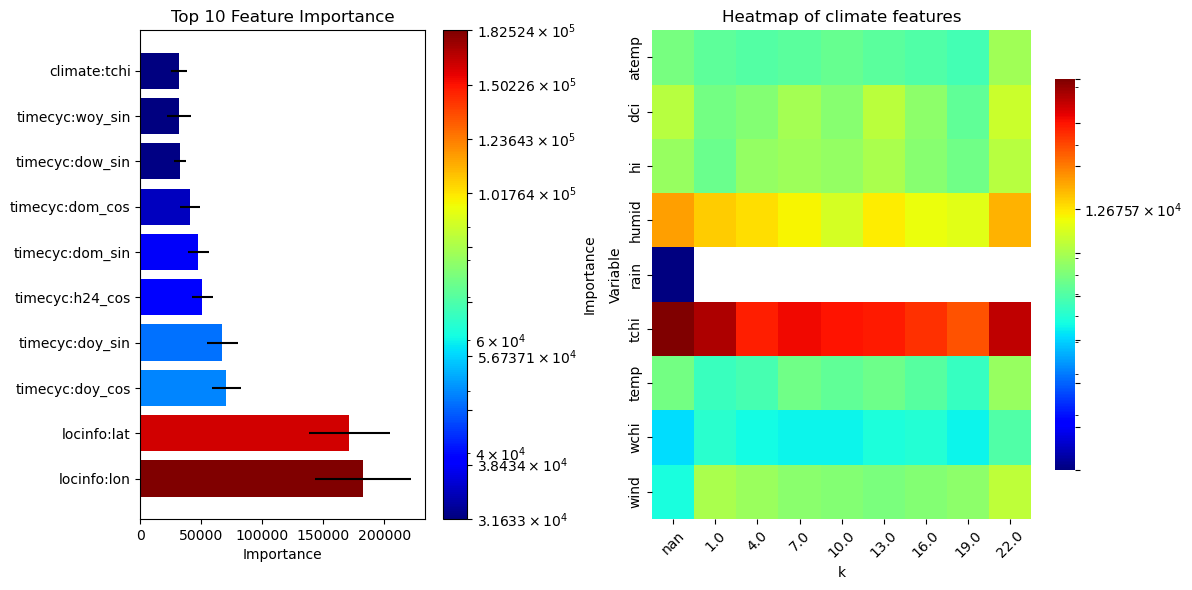

In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LogNorm

# Assuming feature_importances is a DataFrame already defined

# 평균과 표준편차 계산
mean_values = feature_importances.mean()
std_dev = feature_importances.std()
error = std_dev / np.sqrt(len(feature_importances))

# climlag 접두사를 가진 변수 확인
climlag_features = feature_importances.loc[:, feature_importances.columns.str.contains('climlag')]

# climlag 접두사를 제외한 feature importance 히스토그램
non_climlag_features = feature_importances.loc[:, ~feature_importances.columns.str.contains('climlag')]

# 첫 번째 서브플롯: climlag 제외한 feature importance 히스토그램 (상위 10개)
fig, ax = plt.subplots(1, 2, figsize=(12, 6), gridspec_kw={'width_ratios': [3, 4]})

# First subplot: Feature Importance (excluding climlag features)
top_10_non_climlag = non_climlag_features.mean().nlargest(10)
bars = ax[0].barh(top_10_non_climlag.index, top_10_non_climlag.values, xerr=error[top_10_non_climlag.index], color=plt.cm.jet((top_10_non_climlag.values - top_10_non_climlag.values.min()) / (top_10_non_climlag.values.max() - top_10_non_climlag.values.min())))
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=0)
ax[0].set_title('Top 10 Feature Importance')
ax[0].set_xlabel('Importance')

# Add colorbar for ax[0]
sm = plt.cm.ScalarMappable(cmap='jet', norm=LogNorm(vmin=top_10_non_climlag.values.min(), vmax=top_10_non_climlag.values.max()))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax[0], orientation='vertical')
cbar.set_label('Importance')
cbar.set_ticks(np.logspace(np.log10(top_10_non_climlag.values.min()), np.log10(top_10_non_climlag.values.max()), num=10))

# climlag와 climate: 접두사를 가진 변수들 포함
climlag_climate_features = feature_importances.loc[:, feature_importances.columns.str.contains('climlag|climate:')]

# climlag features 히트맵 생성 데이터 준비
climlag_climate_data = climlag_climate_features.T.reset_index()
climlag_climate_data.columns = ['feature'] + list(climlag_climate_data.columns[1:])
climlag_climate_data[['var_climlag', 'k', 'var_climate']] = climlag_climate_data['feature'].str.extract(r'climlag:(.+)_(\d+)|climate:(.+)')
climlag_climate_data['var'] = climlag_climate_data['var_climate'].combine_first(climlag_climate_data['var_climlag'])
climlag_climate_data['avg_r'] = climlag_climate_data[['val_year:2020', 'val_year:2021', 'val_year:2022']].mean(axis=1)
climlag_climate_data['std_r'] = climlag_climate_data[['val_year:2020', 'val_year:2021', 'val_year:2022']].std(axis=1) / np.sqrt(3)

# 'climate:' 변수들을 가장 먼저 표시
climate_vars = climlag_climate_data[climlag_climate_data['feature'].str.contains('climate:')]
climlag_vars = climlag_climate_data[climlag_climate_data['feature'].str.contains('climlag:')]

# climlag_vars는 k에 따라 소팅
climlag_vars['k'] = climlag_vars['k'].astype(int)  # k가 숫자형으로 변환
climlag_vars = climlag_vars.sort_values(by='k')

# 두 데이터를 합침
combined_data = pd.concat([climate_vars, climlag_vars])

# 피벗 테이블 생성
climlag_pivot = combined_data.pivot(index='var', columns='k', values='avg_r')

# Second subplot: Heatmap of climlag and climate features
sns.heatmap(climlag_pivot, annot=False, cmap='jet', norm=LogNorm(vmin=climlag_pivot.min().min(), vmax=climlag_pivot.max().max()), ax=ax[1], cbar_kws={"shrink": 0.8})
ax[1].set_title('Heatmap of climate features')
ax[1].set_xlabel('k')
ax[1].set_ylabel('Variable')
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=45)

# Add colorbar for ax[1]
cbar = ax[1].collections[0].colorbar
cbar.set_ticks(np.logspace(np.log10(climlag_pivot.min().min()), np.log10(climlag_pivot.max().max()), num=10))

# Adjust layout to prevent overlap
fig.tight_layout()

# Show the plot
plt.show()


In [25]:
climlag_data

,feature,val_year:2020,val_year:2021,val_year:2022,var,k
0,climlag:temp_1t3,3388.0,6817.0,9079.0,temp,1
1,climlag:temp_4t6,3838.0,7129.0,9234.0,temp,4
2,climlag:temp_7t9,4307.0,8337.0,10492.0,temp,7
3,climlag:temp_10t12,3833.0,7960.0,10092.0,temp,10
4,climlag:temp_13t15,4163.0,8295.0,10394.0,temp,13
...,...,...,...,...,...,...
59,climlag:hi_10t12,4646.0,9315.0,12111.0,hi,10
60,climlag:hi_13t15,5170.0,9784.0,13015.0,hi,13
61,climlag:hi_16t18,4644.0,8611.0,11743.0,hi,16
62,climlag:hi_19t21,4157.0,8168.0,10880.0,hi,19


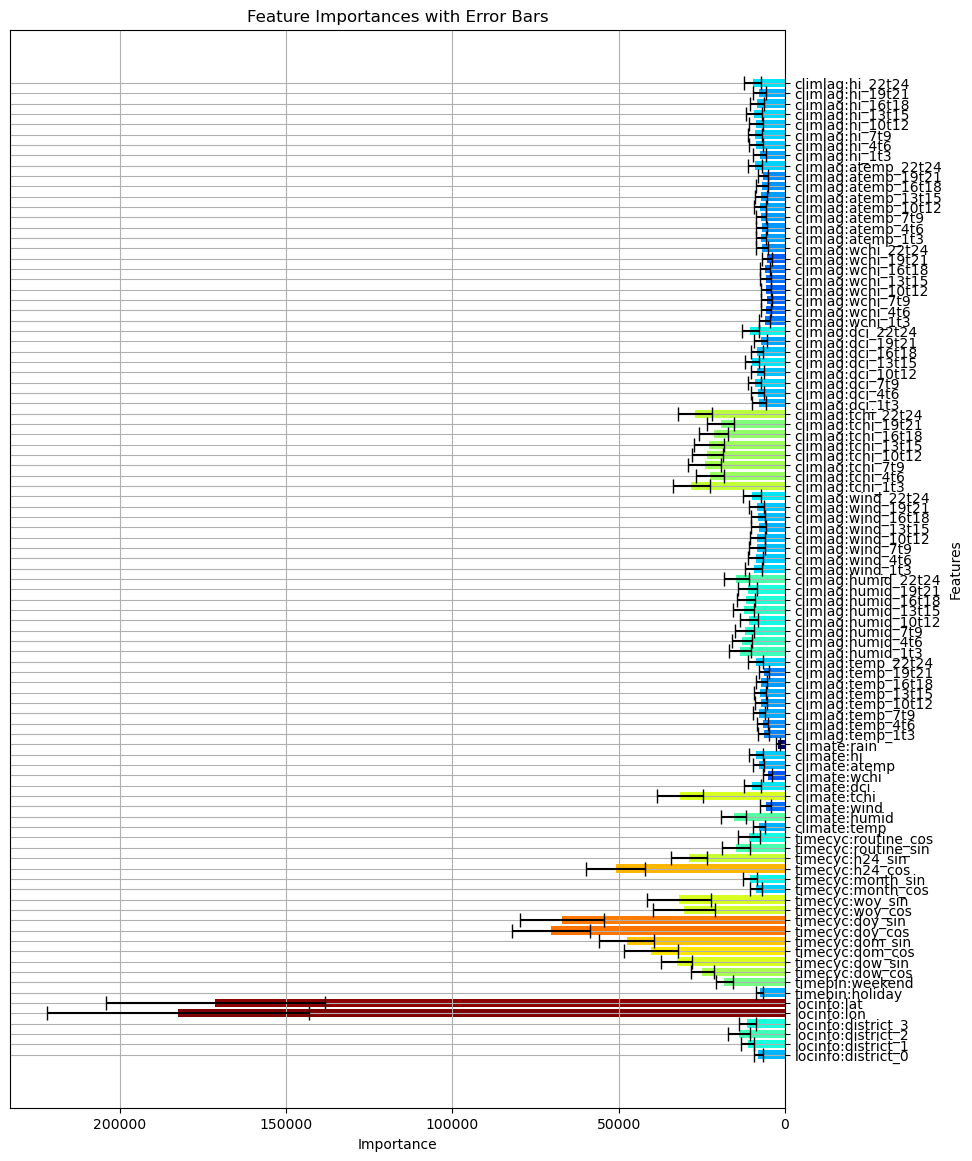

In [12]:


# Sort by mean values
sorting = False  # Set True if you want to sort
if sorting:
    mean_values = mean_values.sort_values(ascending=False)
    error = error[mean_values.index]

# Normalize mean values for color mapping
cval = np.log10(mean_values)

norm = plt.Normalize(vmin=min(cval), vmax=max(cval))
colors = plt.cm.jet(norm(cval))

# Plotting
plt.figure(figsize=(10, 14))
bars = plt.barh(mean_values.index, mean_values, xerr=error, color=colors, ecolor='black', capsize=5)
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importances with Error Bars')
plt.grid(True)

# Invert x-axis to have bars start from the right
plt.gca().invert_xaxis()

# Move y-tick labels to the right
plt.gca().yaxis.tick_right()
plt.gca().yaxis.set_label_position("right")
# adjust half width of the bars, to make them centered
#plt.gca().set_yticks([x + 0.5 for x in range(len(mean_values))])

# Add colorbar
sm = plt.cm.ScalarMappable(cmap='jet', norm=norm)
sm.set_array([])

plt.show()

___

### Little Analysis

In [14]:
val_answers = np.load(val_answers_path)
test_answers = np.load(test_answers_path)

In [25]:
test_answers

NpzFile '/home/minchan/electric/output/xgboost_0627/24-6-26/20-10-23/test_answers.npz' with keys: val_year:2020, val_year:2021, val_year:2022, total

In [16]:
val_answers

NpzFile '/home/minchan/electric/output/xgboost_0627/24-6-26/20-10-23/val_answers.npz' with keys: val_year:2020, val_year:2021, val_year:2022

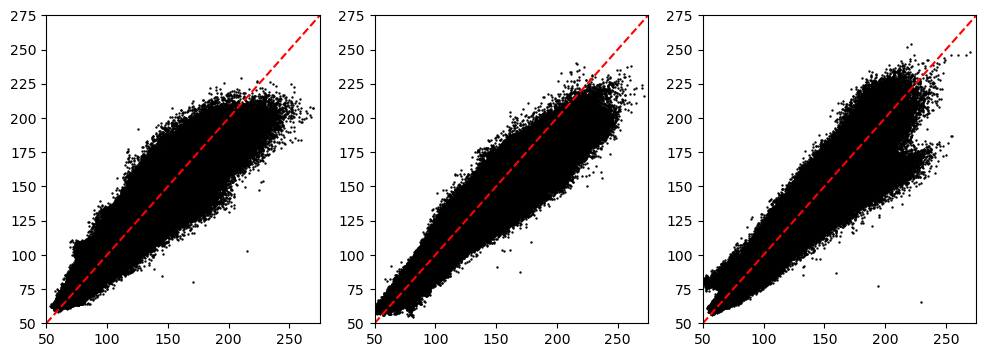

In [19]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))

for i, year in enumerate([2020, 2021, 2022]):
    ax[i].scatter(elec_dict[year], val_answers[f'val_year:{year}'],s=0.5, c='k')
    ax[i].set_xlim(50, 275)
    ax[i].set_ylim(50, 275)
    ax[i].plot([50, 275], [50, 275], 'r--')

In [23]:
def npz_to_dict(npz):
    return {key: npz[key] for key in npz.files}

test_answers_dict = npz_to_dict(test_answers)

test_answers_df = pd.DataFrame(test_answers_dict)

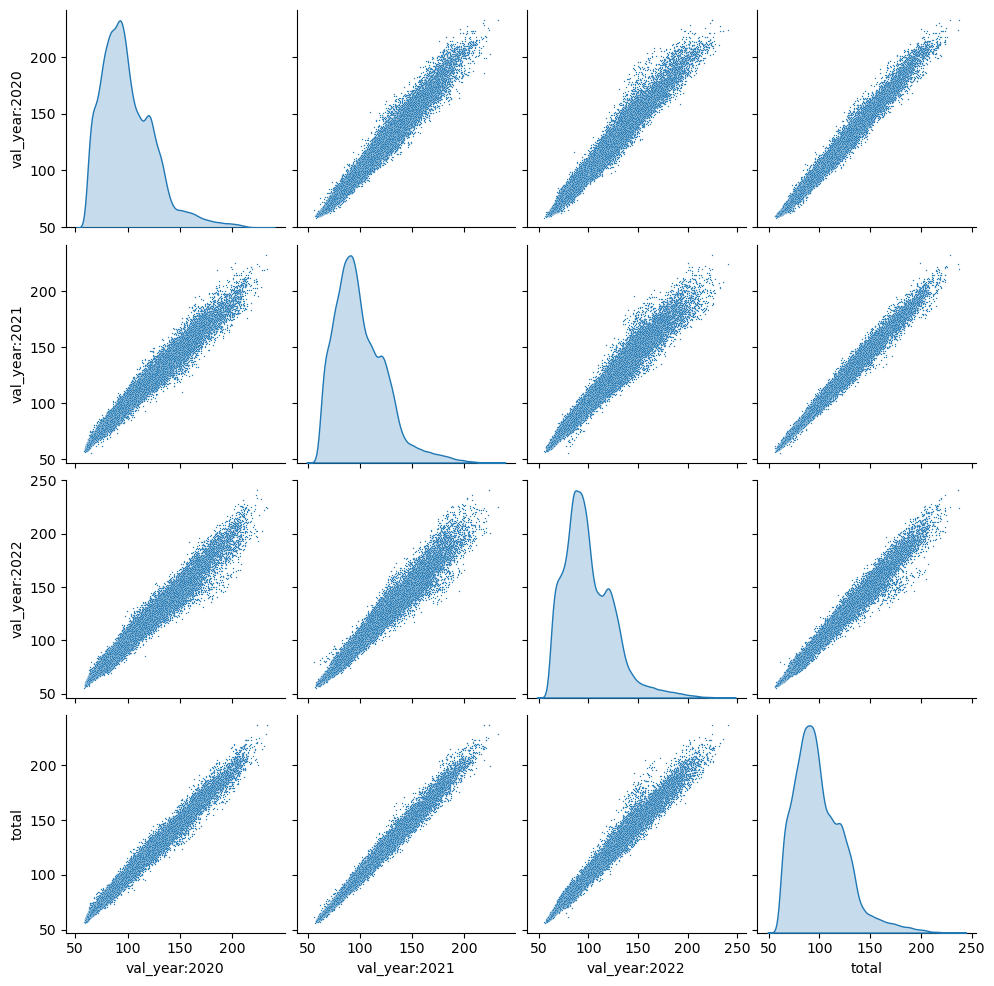

In [24]:
# get pairplot of test answers
# 

sample = test_answers_df.sample(100000)
import seaborn as sns

sns.pairplot(sample, diag_kind='kde', plot_kws={'s': 1})
plt.show()

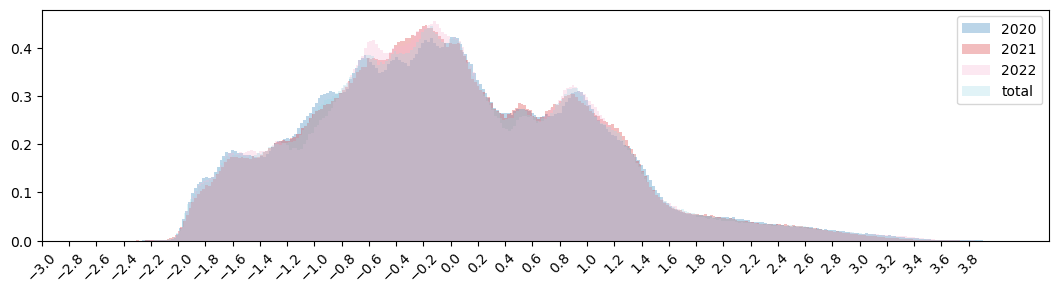

In [65]:

plt.figure(figsize=(13, 3))

# 'tab20' colormap을 가져오고, 필요한 색상만큼 추출하여 새로운 colormap을 만듭니다.
base_colormap = plt.get_cmap('tab20')
colors = base_colormap(np.linspace(0, 1, len(answer_df.columns)))
colormap = plt.cm.colors.ListedColormap(colors)

for I, val_year in enumerate(answer_df.columns):
    answers = answer_df[val_year]
    answers = (np.log10(answers) - 1.9875)/ 0.1028
    plt.hist(answers, bins=300, label=val_year, alpha=0.3, color=colormap(I), density=True)

plt.xticks(np.arange(-3, 4, 0.2), rotation=45)

plt.legend()
plt.show()

___